<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Testing different Hyperparameters and Benchmarking

In this notebook, we'll cover how to test different hyperparameters for a particular dataset and how to benchmark different parameters across a group of datasets.

## Table of Contents

* [Testing hyperparameters](#hyperparam)
  * [Using Python](#python)
  * [Using the CLI](#cli)
  * [Visualizing the results](#visualize)

---

## Testing hyperparameters  <a name="hyperparam"></a>

Let's say we want to learn more about __how different learning rates and different image sizes affect our model's accuracy when restricted to 10 epochs__, and we want to build an experiment to test out these hyperparameters. We also want to try these parameters out on two different variations of the dataset - one where the images are kept raw (maybe there is a watermark on the image) and one where the images have been altered (the same dataset where there was some attempt to remove the watermark).

In this notebook, we'll walk through how we use the Parameter Sweeper module with the following:

- use python to perform this experiment
- use the CLI to perform this experiment
- evalute the results using Pandas

Check out fastai version.

In [1]:
import fastai
fastai.__version__

'1.0.48'

Ensure edits to libraries are loaded and plotting is shown in the notebook.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We start by importing the utilities we need.

In [3]:
import sys
sys.path.append("../../")
from utils_cv.classification.data import Urls
from utils_cv.common.data import unzip_url
from utils_cv.classification.parameter_sweeper import ParameterSweeper, clean_sweeper_df, plot_sweeper_df

To use the Parameter Sweeper tool for single label classification, we'll need to make sure that the data is stored such that images are sorted into their classes inside of a subfolder. In this notebook, we'll use the Fridge Objects dataset, which is already stored in the correct format. We also want to use the Fridge Objects Watermarked dataset. We want to see whether the original images (which are watermarked) will perform just as well as the non-watermarked images.

Define some parameters we will use in this notebook

In [4]:
DATA = [unzip_url(Urls.fridge_objects_path, exist_ok=True), unzip_url(Urls.fridge_objects_watermark_path, exist_ok=True)]
REPS = 3
LEARNING_RATES = [1e-3, 1e-4, 1e-5]
IM_SIZES = [299, 499]
EPOCHS = [10]

### Using Python <a name="python"></a>

We start by creating the Parameter Sweeper object:

In [5]:
sweeper = ParameterSweeper()

Before we start testing, it's a good idea to see what the default parameters are. We can use a the property `parameters` to easily see those default values.

In [6]:
sweeper.parameters

OrderedDict([('learning_rate', [0.0001]),
             ('epochs', [15]),
             ('batch_size', [16]),
             ('im_size', [299]),
             ('architecture',
              [<Architecture.resnet18: functools.partial(<function resnet18 at 0x7ff70f5eef28>)>]),
             ('transform', [True]),
             ('dropout', [0.5]),
             ('weight_decay', [0.01]),
             ('training_schedule',
              [<TrainingSchedule.head_first_then_body: 'head_first_then_body'>]),
             ('discriminative_lr', [False]),
             ('one_cycle_policy', [True])])

Now that we know the defaults, we can pass it the parameters we want to test. 

In this notebook, we want to see the effect of different learning rates across different image sizes using only 10 epochs (the default number of epochs is 15). To do so, I would run the `update_parameters` functions as follows:

```python
sweeper.update_parameters(learning_rate=[1e-3, 1e-4, 1e-5], im_size=[299, 499], epochs=[10])
```

Notice that all parameters must be passed in as a list, including single values such the number of epochs.

These parameters will be used to calculate the number of permutations to run. In this case, we've pass in three options for learning rates, two for image sizes, and one for number of epochs. This will result in 3 X 2 X 1 total permutations (in otherwords, 6 permutations). 

In [7]:
sweeper.update_parameters(learning_rate=LEARNING_RATES, im_size=IM_SIZES, epochs=EPOCHS)

Now that we have our parameters defined, we call the `run()` function with the dataset to test on. We can also optionally pass in:
- the number of repetitions to run each permutation (default is 3)
- whether or not we want the training to stop early if the metric (accuracy) doesn't improve by 0.01 (1%) over 3 epochs (default is False)

The `run` function returns a multi-index dataframe which we can work with right away.

In [8]:
df = sweeper.run(datasets=DATA, reps=REPS); df

this Learner object self-destroyed - it still exists, but no longer usable


duration  \
0 PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects           14.857378   
                                                     fridgeObjectsWatermark  14.883626   
  PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects           22.234625   
                                                     fridgeObjectsWatermark  22.293807   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects           19.317119   
                                                     fridgeObjectsWatermark  15.197233   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects           23.473061   
                                                     fridgeObjectsWatermark  22.655902   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects           14.894483   
                                                     fridgeObjectsWatermark  15.040211   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects           22.189479   
                                                     fridgeObjectsWatermark  22.122559   
1 PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects           14.964945   
                                                     fridgeObjectsWatermark  14.880900   
  PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects           22.379199   
                                                     fridgeObjectsWatermark  22.235614   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects           14.839557   
                                                     fridgeObjectsWatermark  14.869665   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects           22.397468   
                                                     fridgeObjectsWatermark  22.424992   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects           14.887680   
                                                     fridgeObjectsWatermark  15.046079   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects           22.304453   
                                                     fridgeObjectsWatermark  22.299263   
2 PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects           14.962609   
                                                     fridgeObjectsWatermark  15.042777   
  PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects           22.444724   
                                                     fridgeObjectsWatermark  22.240431   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects           15.305201   
                                                     fridgeObjectsWatermark  15.175673   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects           22.186188   
                                                     fridgeObjectsWatermark  22.715623   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects           14.979280   
                                                     fridgeObjectsWatermark  15.063931   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects           22.407238   
                                                     fridgeObjectsWatermark  22.100421   

                                                                             accuracy  
0 PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects           0.909091  
                                                     fridgeObjectsWatermark  0.886364  
  PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects           0.863636  
                                                     fridgeObjectsWatermark  0.704545  
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects           0.886364  
                                                     fridgeObjectsWatermark  0.886364  
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects           0.954545  
                                           

### Using the CLI <a name="cli"></a>

Instead of using python to run this experiment, we may want to test from the CLI. We can do so by using the `scripts/sweep.py` file. 

To reproduce the same test (different learning rates across different image sizes using only 10 epochs), and the same settings (3 repetitions, and no early_stopping) we can run the following:

```sh
python scripts/sweep.py 
    --learning-rates 1e-3 1e-4 1e-5
    --im-size 99 299
    --epochs 10 
    --repeat 3 
    --no-early-stopping 
    --inputs <my-data-dir>
    --output lr_bs_test.csv
```

Additionally, we've added an output parameter, which will automatically dump our dataframe into a csv file. To simplify the command, we can use the acryonyms of the params. We can also remove `--no-early-stopping` as that is the default behavior.

```sh
python scripts/sweep.py -lr 1e-3 1e-4 1e-5 -is 99 299 -e 10 -i <my-data-dir> -o lr_bs_test.csv
```

Once the script completes, load the csv into a dataframe to explore it's contents. We'll want to specify `index_col=[0, 1, 2]` since it is a multi-index dataframe.

```python
df = pd.read_csv("data/lr_bs_test.csv", index_col=[0, 1, 2])
```

HINT: You can learn more about how to use the script with the `--help` flag.

```python
python scripts/sweep.py --help
```

### Visualize Results <a name="visualize"></a>

When we read in multi-index dataframe, index 0 represents the run number, index 1 represents a single permutation of parameters, and index 2 represents the dataset.

To see the results, show the df using the `clean_sweeper_df` helper function. This will display all the hyperparameters in a nice, readable way.

In [9]:
df = clean_sweeper_df(df)

Since we've run our benchmarking over 3 repetitions, we may want to just look at the averages across the different __run numbers__.

In [10]:
df.mean(level=(1,2)).T

P: [learning_rate: 0.0001] [im_size: 299]                         \
                                     fridgeObjects fridgeObjectsWatermark   
duration                                 14.928311              14.935768   
accuracy                                  0.787879               0.840909   

         P: [learning_rate: 0.0001] [im_size: 499]                         \
                                     fridgeObjects fridgeObjectsWatermark   
duration                                 22.352849              22.256617   
accuracy                                  0.840909               0.643939   

         P: [learning_rate: 0.001] [im_size: 299]                         \
                                    fridgeObjects fridgeObjectsWatermark   
duration                                16.487292              15.080857   
accuracy                                 0.893939               0.924243   

         P: [learning_rate: 0.001] [im_size: 499]                         \
                                    fridgeObjects fridgeObjectsWatermark   
duration                                22.685572              22.598839   
accuracy                                 0.916667               0.916666   

         P: [learning_rate: 1e-05] [im_size: 299]                         \
                                    fridgeObjects fridgeObjectsWatermark   
duration                                14.920481              15.050074   
accuracy                                 0.318182               0.363636   

         P: [learning_rate: 1e-05] [im_size: 499]                         
                                    fridgeObjects fridgeObjectsWatermark  
duration                                22.300390              22.174081  
accuracy                                 0.348485               0.287879

Print the average accuracy over the different runs for each dataset independently.

[Text(0, 0, '0.00%'),
 Text(0, 0, '20.00%'),
 Text(0, 0, '40.00%'),
 Text(0, 0, '60.00%'),
 Text(0, 0, '80.00%'),
 Text(0, 0, '100.00%')]

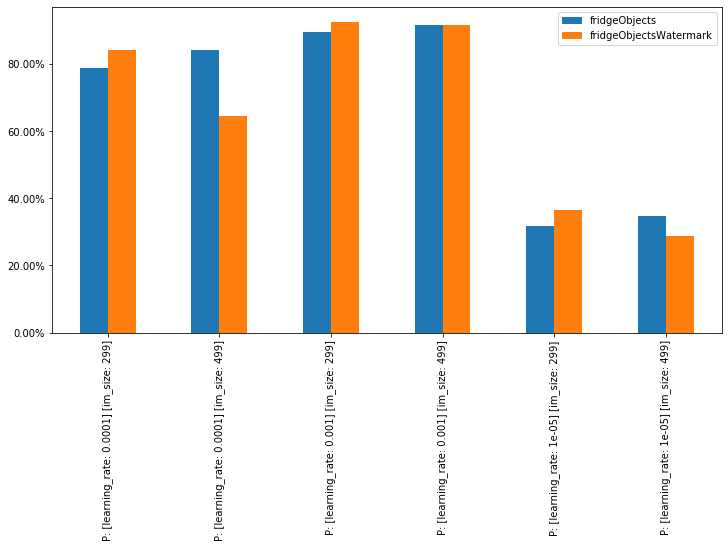

In [11]:
ax = df.mean(level=(1,2))["accuracy"].unstack().plot(kind='bar', figsize=(12, 6))
ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])

Additionally, we may want simply to see which set of hyperparameters perform the best across the different __datasets__. We can do that by averaging the results of the different datasets.

In [12]:
df.mean(level=(1)).T

,P: [learning_rate: 0.0001] [im_size: 299],P: [learning_rate: 0.0001] [im_size: 499],P: [learning_rate: 0.001] [im_size: 299],P: [learning_rate: 0.001] [im_size: 499],P: [learning_rate: 1e-05] [im_size: 299],P: [learning_rate: 1e-05] [im_size: 499]
duration,14.932039,22.304733,15.784075,22.642206,14.985277,22.237236
accuracy,0.814394,0.742424,0.909091,0.916667,0.340909,0.318182


To make it easier to see which permutation did the best, we can plot the results using the `plot_sweeper_df` helper function. This plot will help us easily see which parameters offer the highest accuracies.

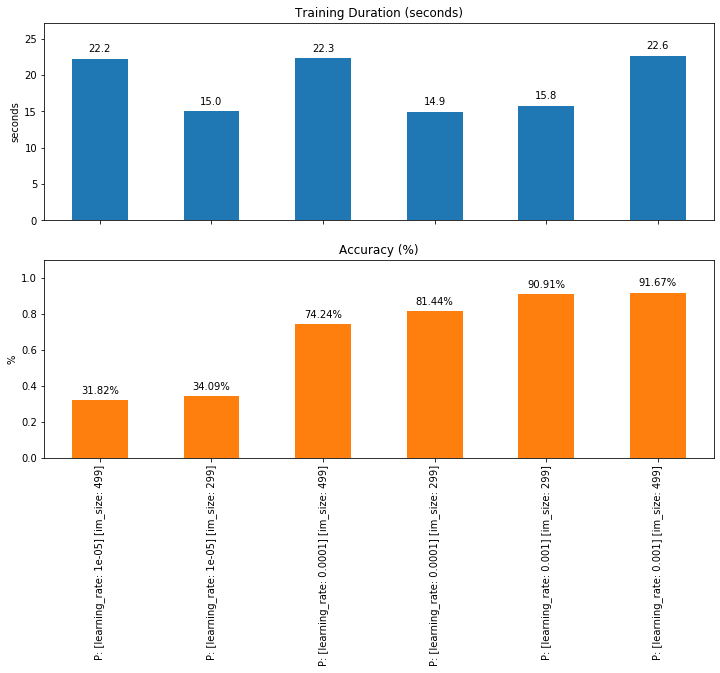

In [13]:
plot_sweeper_df(df.mean(level=(1)), sort_by="accuracy")